# Linear regression

### Import libraries and set random state

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

random_state = 44

### Import and scale data

In [131]:
df = pd.read_csv("../features.csv", index_col=0)
df.dropna(inplace=True)
X = df.drop(columns=['malign', 'patient_name', 'file_name'])
y = df['malign']

In [132]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

In [156]:
from sklearn.model_selection import GridSearchCV
svc = SVC(random_state=random_state, probability=True, max_iter=10**4)
params = {"C":[1, 10, 100, 1000], "gamma": [0.1, 0.01, 0.001]}
grid_search = GridSearchCV(svc, params)
grid_search.fit(X_train,y_train)


c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  Conv

GridSearchCV(estimator=SVC(max_iter=10000, probability=True, random_state=44),
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001]})

In [157]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 0.1}


### Pick best percentiles for filter methods

In [134]:
from sklearn.feature_selection import GenericUnivariateSelect, \
    VarianceThreshold, mutual_info_classif, chi2, f_classif
from sklearn.metrics import f1_score
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline

percentiles = [1, 3, 6, 10, 30, 60, 67, 90]
results = {"mutual_info_classif": [], "chi2": [], "f_classif": []}
GUS_pipe_best_dict = {}
score_funcs = [mutual_info_classif, chi2, f_classif]
best_f1 = 0
GUS_pipe_best = None
percentile_best = None
for fun, name in zip(score_funcs, list(results.keys())):
    best_f1 = 0
    for percentile in percentiles:
        GUS_pipe = Pipeline([("VarianceThreshold", VarianceThreshold()), 
                             ("FeatureSelection", GenericUnivariateSelect(score_func=fun, param=percentile)),
                             ("SVM", SVC(C=10, gamma=0.1, random_state=random_state, max_iter=10**4, probability=True))])
        GUS_pipe.fit(X_train, y_train)
        f1 = f1_score(y_val, GUS_pipe.predict(X_val))
        results[name].append(f1)
        if f1 > best_f1:
            best_f1 = f1
            GUS_pipe_best = GUS_pipe
            percentile_best = percentile
    GUS_pipe_best_dict[name] = GUS_pipe_best
    print(f'{name}, best pericentile: {percentile_best}, best f1: {best_f1}')

mutual_info_classif, best pericentile: 10, best f1: 0.5283018867924528
chi2, best pericentile: 60, best f1: 0.48
f_classif, best pericentile: 10, best f1: 0.43999999999999995


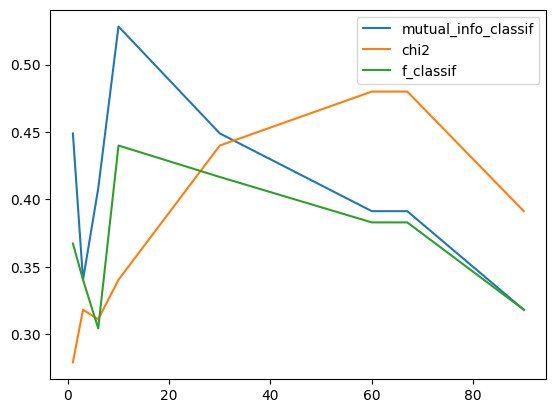

In [135]:
for fun, name in zip(score_funcs, results.keys()):
    plt.plot(percentiles, results[name])
plt.legend(results.keys())
plt.show()

### Create 4 models - 3 with filter selection, 1 with wrapper selection

In [136]:
from sklearn.feature_selection import GenericUnivariateSelect, RFECV, \
    VarianceThreshold, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer

GUS_MI = GUS_pipe_best_dict["mutual_info_classif"]
GUS_CHI = GUS_pipe_best_dict["chi2"]
GUS_FC = GUS_pipe_best_dict["f_classif"]

f1_scorer = make_scorer(f1_score)
clf_RFECV = RFECV(estimator=SVC(kernel='linear',random_state=random_state, max_iter=10**4, probability=True),
                  scoring=f1_scorer,
                  step=0.05, n_jobs=-1)
SVM_var = Pipeline([('VarianceThreshold', VarianceThreshold()), ("SVM", SVC(C=10, gamma=0.1,random_state=random_state, probability=True, max_iter=10**4))])
SVM = SVC(C=10, gamma=0.1, random_state=random_state, probability=True, max_iter=10**4)
# SFS = Pipeline([("FeatureSelection", SequentialFeatureSelector(
#                                 estimator=LogisticRegression(random_state=random_state, max_iter=100), 
#                                 scoring=f1_scorer, 
#                                 n_jobs=-1)),
#                 ("LogisticRegression", LogisticRegression(random_state=random_state, max_iter=10**4))])

clfs = [GUS_MI, GUS_CHI, GUS_FC, clf_RFECV, SVM_var, SVM]
clfs_names = ["GUS Mutual Info", "GUS chi-squared", "GUS ANOVA F-value", "RFECV", "SVM_var", "SVM"]

for clf, name in zip(clfs, clfs_names):
    print("Fitting: ", name)
    clf = clf.fit(X_train, y_train)

Fitting:  GUS Mutual Info
Fitting:  GUS chi-squared
Fitting:  GUS ANOVA F-value
Fitting:  RFECV
Fitting:  SVM_var
Fitting:  SVM


### Evaluate performance

In [137]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_train)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_train)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_train, y_pred))
    results['F1 score'].append(f1_score(y_train, y_pred))
    results['Precision'].append(precision_score(y_train, y_pred))
    results['Recall'].append(recall_score(y_train, y_pred))

results_df = pd.DataFrame(results)
print("Performance on TRAINING set")
results_df.head(len(clfs_names))

Performance on TRAINING set


,Name,Accuracy,F1 score,Precision,Recall
0,GUS Mutual Info,0.809833,0.537246,0.843972,0.394040
1,GUS chi-squared,0.810761,0.538462,0.850000,0.394040
2,GUS ANOVA F-value,0.811688,0.547884,0.836735,0.407285
3,RFECV,0.844156,0.648536,0.880682,0.513245
4,SVM_var,0.783859,0.416040,0.855670,0.274834
5,SVM,0.782004,0.408060,0.852632,0.268212


In [138]:
y_pred = clf.predict(X_val)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_val)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_val, y_pred))
    results['F1 score'].append(f1_score(y_val, y_pred))
    results['Precision'].append(precision_score(y_val, y_pred))
    results['Recall'].append(recall_score(y_val, y_pred))

results_df = pd.DataFrame(results)
print("Performance on VALIDATION set")
results_df.head(len(clfs_names))

Performance on VALIDATION set


,Name,Accuracy,F1 score,Precision,Recall
0,GUS Mutual Info,0.814815,0.509804,0.866667,0.361111
1,GUS chi-squared,0.807407,0.480000,0.857143,0.333333
2,GUS ANOVA F-value,0.792593,0.440000,0.785714,0.305556
3,RFECV,0.844444,0.631579,0.857143,0.500000
4,SVM_var,0.785185,0.325581,1.000000,0.194444
5,SVM,0.785185,0.325581,1.000000,0.194444


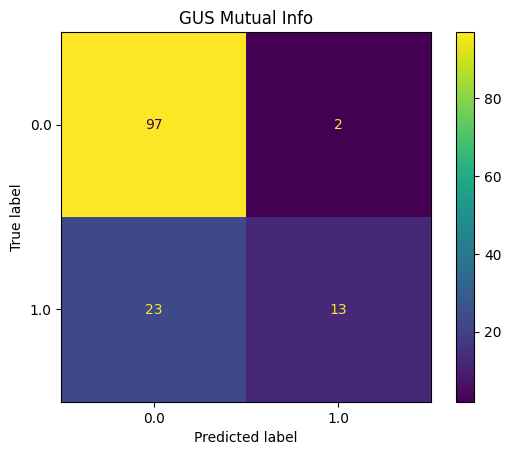

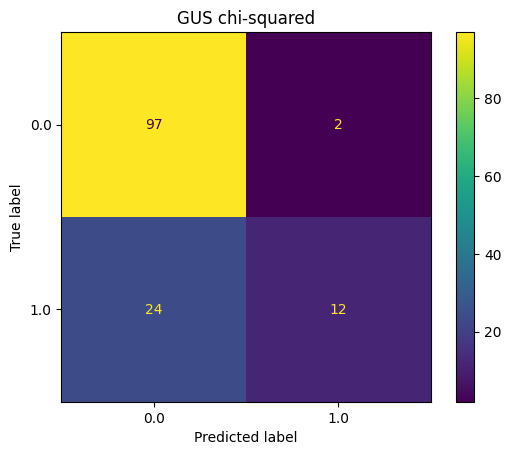

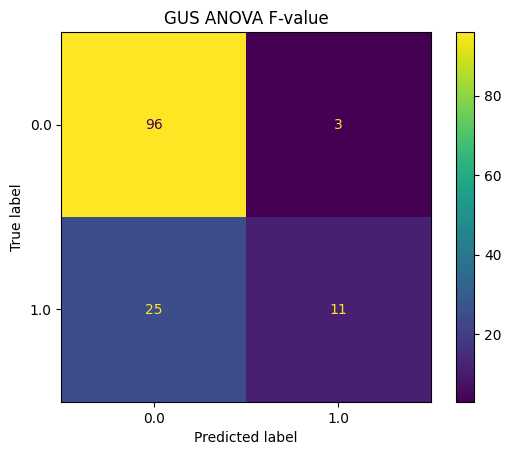

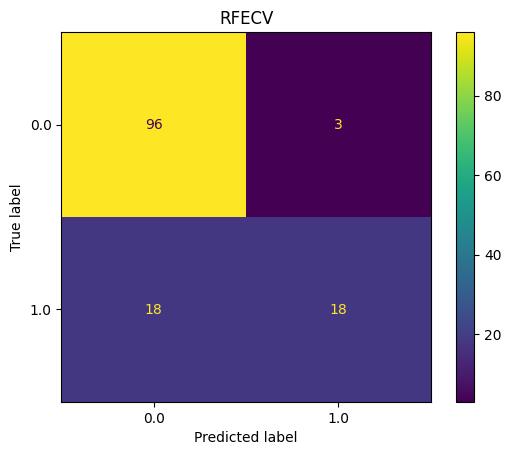

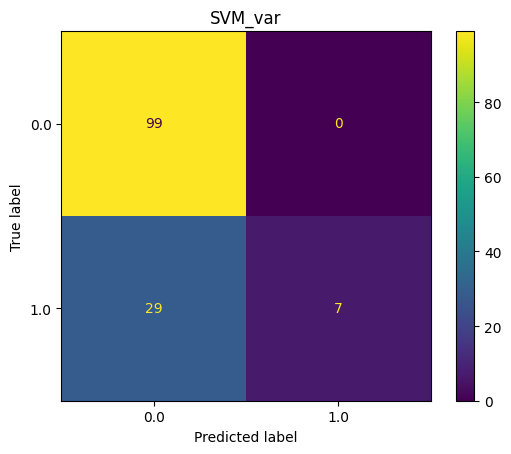

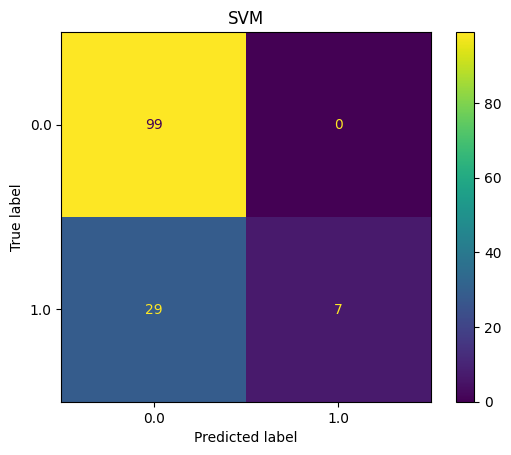

In [139]:
for clf, name in zip(clfs, clfs_names):
    y_pred = ys_pred[name]
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()

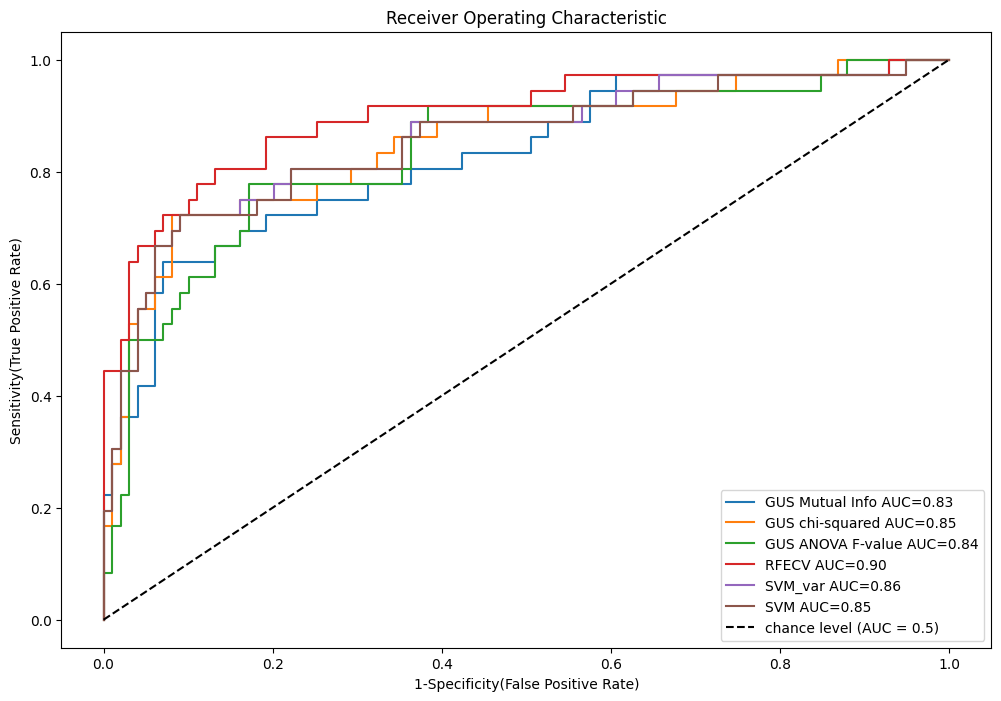

In [140]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
ys_pred_proba = {}
clfs_thresholds = {}
plt.figure(figsize=(12,8))
for clf, name in zip(clfs, clfs_names):
    y_pred_proba = clf.predict_proba(X_val)
    y_pred_proba = y_pred_proba[:, 1]
    ys_pred_proba[name] = y_pred_proba

    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    thresholds = np.append(thresholds, 0.5)
    clfs_thresholds[name] = thresholds
    plt.plot(fpr,tpr,label=f"{name} AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [141]:
best_thresholds = {}
for clf, name in zip(clfs, clfs_names):
    best_f1 = 0
    best_th = None
    for threshold in clfs_thresholds[name]:
        y_pred = ys_pred_proba[name] > threshold
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_th = threshold
    best_thresholds[name] = best_th

In [142]:
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred = ys_pred_proba[name] > best_th
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_val, y_pred))
    results['F1 score'].append(f1_score(y_val, y_pred))
    results['Precision'].append(precision_score(y_val, y_pred))
    results['Recall'].append(recall_score(y_val, y_pred))
    results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on VALIDATION")
results_df.head(len(clfs_names))

Results after threshold adjustment on VALIDATION


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,GUS Mutual Info,0.844444,0.676923,0.758621,0.611111,0.335916
1,GUS chi-squared,0.859259,0.724638,0.757576,0.694444,0.272602
2,GUS ANOVA F-value,0.807407,0.675000,0.613636,0.750000,0.212778
3,RFECV,0.874074,0.746269,0.806452,0.694444,0.437543
4,SVM_var,0.859259,0.724638,0.757576,0.694444,0.320510
5,SVM,0.859259,0.724638,0.757576,0.694444,0.328489


In [143]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_test)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_test)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 score'].append(f1_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))

results_df = pd.DataFrame(results)
print("Results WITHOUT threshold adjustment on TEST data")
results_df.head(len(clfs_names))

Results WITHOUT threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall
0,GUS Mutual Info,0.800000,0.490566,0.812500,0.351351
1,GUS chi-squared,0.800000,0.490566,0.812500,0.351351
2,GUS ANOVA F-value,0.814815,0.509804,0.928571,0.351351
3,RFECV,0.844444,0.644068,0.863636,0.513514
4,SVM_var,0.762963,0.304348,0.777778,0.189189
5,SVM,0.762963,0.304348,0.777778,0.189189


In [144]:
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}
ys_pred_test_proba = {}

for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    ys_pred_test_proba[name] = y_pred_proba
    y_pred = y_pred_proba > best_th
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 score'].append(f1_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on TEST data")
results_df.head(len(clfs_names))

Results after threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,GUS Mutual Info,0.785185,0.579710,0.625000,0.540541,0.335916
1,GUS chi-squared,0.740741,0.533333,0.526316,0.540541,0.272602
2,GUS ANOVA F-value,0.740741,0.556962,0.523810,0.594595,0.212778
3,RFECV,0.822222,0.625000,0.740741,0.540541,0.437543
4,SVM_var,0.762963,0.555556,0.571429,0.540541,0.320510
5,SVM,0.762963,0.555556,0.571429,0.540541,0.328489


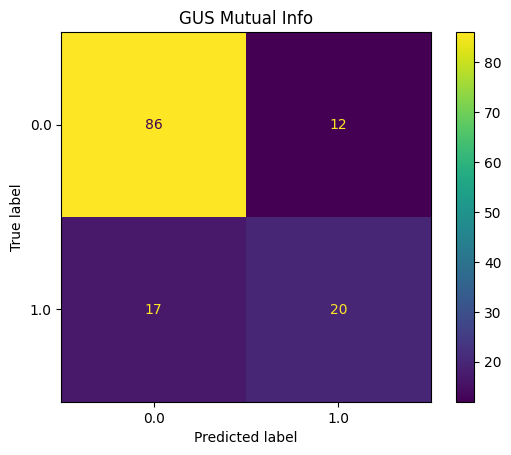

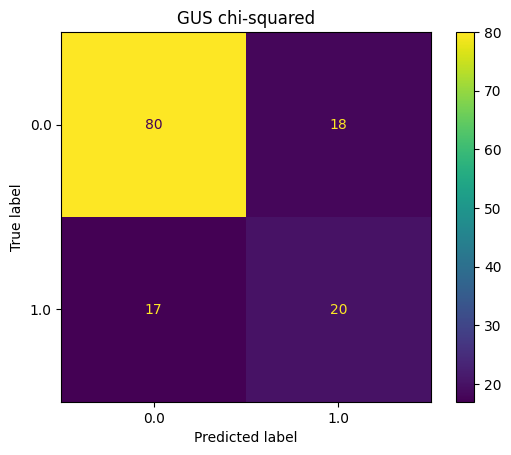

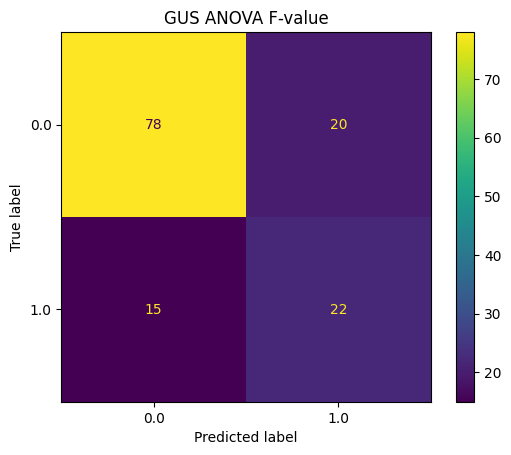

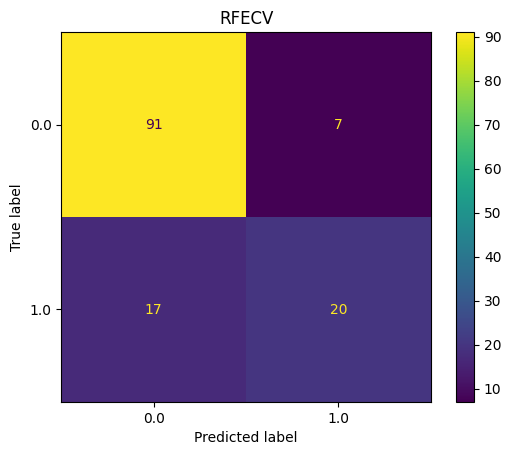

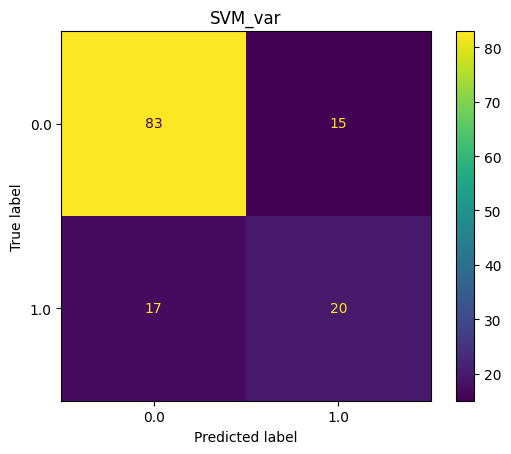

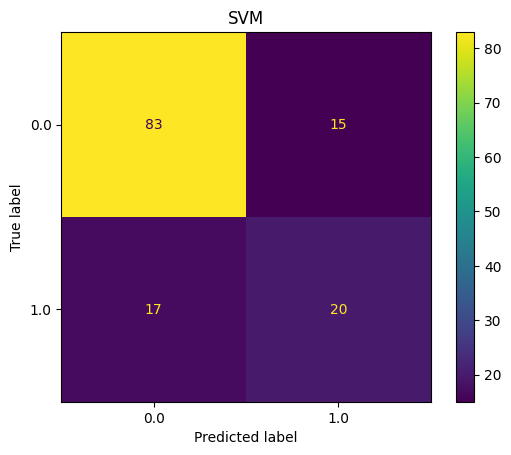

In [145]:
for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    ys_pred_test_proba[name] = y_pred_proba
    y_pred = y_pred_proba > best_th
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()

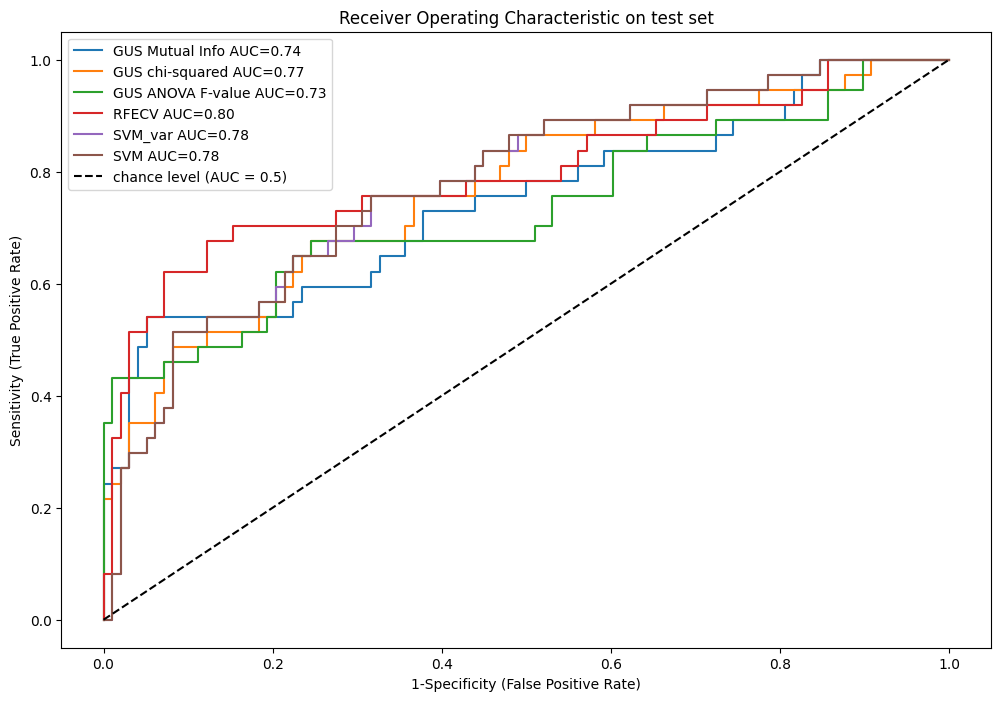

In [146]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
ys_pred_proba = {}
clfs_thresholds = {}
plt.figure(figsize=(12,8))
for clf, name in zip(clfs, clfs_names):
    y_pred_proba = clf.predict_proba(X_test)
    y_pred_proba = y_pred_proba[:, 1]
    ys_pred_proba[name] = y_pred_proba

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    clfs_thresholds[name] = thresholds

    plt.plot(fpr,tpr,label=f"{name} AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic on test set')
plt.legend()
plt.show()

### Review feature selection

In [147]:

from sklearn.feature_selection import SelectFromModel

def count_classes(selected, feature_classes, original=None):
    results = []
    sum = 0
    for feature_class in feature_classes:
        counter = 0
        for elem in selected:
            if feature_class == 'square':
                if feature_class in elem and 'squareroot' not in elem:
                    counter += 1
            elif feature_class in elem:
                counter += 1
        sum += counter
        results.append([feature_class, counter])
    results.append(["sum", sum])
    results = pd.DataFrame(results, columns=["Feature class name", "Count"])

    if original is not None:
        original_count = count_classes(original, feature_classes)["Count"]
        results["Percent kept"] = results["Count"] / original_count
        results["Original Count"] = original_count

    results.head(len(feature_classes))
    return results

def get_selected_from_support(support, columns):
    df_selected = pd.DataFrame({'Column': columns,
                             'Kept': support})
    selected = df_selected[df_selected['Kept'] == True]['Column']
    return selected

feature_classes = ['lbp-2D', 'gradient', 'exponential', 'logarithm', 'squareroot', 'square', 'wavelet-L', 'wavelet-H', 'original']


X = df.drop(columns=['malign', 'patient_name', 'file_name'])

selected = get_selected_from_support(clf_RFECV.support_, X.columns)
count_classes(selected, feature_classes, X.columns)

,Feature class name,Count,Percent kept,Original Count
0,lbp-2D,6,0.065934,91
1,gradient,7,0.076923,91
2,exponential,8,0.087912,91
3,logarithm,9,0.098901,91
4,squareroot,9,0.098901,91
5,square,13,0.142857,91
6,wavelet-L,12,0.131868,91
7,wavelet-H,12,0.131868,91
8,original,14,0.140000,100
9,sum,90,0.108696,828


In [148]:
selected_after_var = get_selected_from_support(GUS_CHI["VarianceThreshold"].get_support(), X.columns)
selected = get_selected_from_support(GUS_CHI["FeatureSelection"].get_support(), selected_after_var)
count_classes(selected, feature_classes, selected_after_var)

,Feature class name,Count,Percent kept,Original Count
0,lbp-2D,19,0.372549,51
1,gradient,66,0.725275,91
2,exponential,58,0.637363,91
3,logarithm,43,0.472527,91
4,squareroot,58,0.637363,91
5,square,54,0.593407,91
6,wavelet-L,58,0.637363,91
7,wavelet-H,48,0.527473,91
8,original,69,0.690000,100
9,sum,473,0.600254,788


In [149]:
selected_after_var = get_selected_from_support(GUS_FC["VarianceThreshold"].get_support(), X.columns)
selected = get_selected_from_support(GUS_FC["FeatureSelection"].get_support(), selected_after_var)
count_classes(selected, feature_classes, selected_after_var)

,Feature class name,Count,Percent kept,Original Count
0,lbp-2D,2,0.039216,51
1,gradient,12,0.131868,91
2,exponential,2,0.021978,91
3,logarithm,0,0.000000,91
4,squareroot,3,0.032967,91
5,square,6,0.065934,91
6,wavelet-L,23,0.252747,91
7,wavelet-H,7,0.076923,91
8,original,23,0.230000,100
9,sum,78,0.098985,788


In [150]:
selected_after_var = get_selected_from_support(GUS_MI["VarianceThreshold"].get_support(), X.columns)
selected = get_selected_from_support(GUS_MI["FeatureSelection"].get_support(), selected_after_var)
count_classes(selected, feature_classes, selected_after_var)

,Feature class name,Count,Percent kept,Original Count
0,lbp-2D,0,0.000000,51
1,gradient,4,0.043956,91
2,exponential,7,0.076923,91
3,logarithm,9,0.098901,91
4,squareroot,5,0.054945,91
5,square,19,0.208791,91
6,wavelet-L,11,0.120879,91
7,wavelet-H,15,0.164835,91
8,original,9,0.090000,100
9,sum,79,0.100254,788
